<a href="https://colab.research.google.com/github/eyao600/resnet9/blob/main/resnet_fp_fx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##The Resnet Research paper can be accessed from here https://arxiv.org/pdf/1512.03385v1.pdf

# **Checking availability of GPU. Google Colab provides a NVIDIA Tesla

K80 GPU for free for 12 hours.**

##Some Features of Tesla K80

1.4992 NVIDIA CUDA cores with a dual-GPU design

2.Up to 2.91 teraflops double-precision performance with NVIDIA GPU Boost

3.Up to 8.73 teraflops single-precision performance with NVIDIA GPU Boost

3.24 GB of GDDR5 memory

4.480 GB/s aggregate memory bandwidth

5.ECC protection for increased reliability

6.Server-optimised to deliver the best throughput in the data center


#**CUDA®**
CUDA® is a parallel computing platform and programming model developed by NVIDIA for general computing on graphical processing units (GPUs). With CUDA, developers are able to dramatically speed up computing applications by harnessing the power of GPUs.

In GPU-accelerated applications, the sequential part of the workload runs on the CPU – which is optimized for single-threaded performance – while the compute intensive portion of the application runs on thousands of GPU cores in parallel. When using CUDA, developers program in popular languages such as C, C++, Fortran, Python and MATLAB and express parallelism through extensions in the form of a few basic keywords.

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available.  Training on CPU ...')
else:
  print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


#**Downloading the CIFAR10 datset and loading the data in Normalized form as torch.FloatTensor datatype and generating a validation set by dividing the training set in 80-20 ratio**
#**CIFAR10**
The CIFAR10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset:
1. airplane
2. automobile
3. bird
4. cat
5. deer
6. dog
7. frog
8. horse
9. ship
10. truck

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

More can be read from their page at https://www.cs.toronto.edu/~kriz/cifar.html

#**Image Augmentation**
In this cell, we perform some simple data augmentation by randomly flipping and cropping the given image data. We do this by defining a torchvision transform, and you can learn about all the transforms that are used to pre-process and augment data from the [PyTorch documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
print('==> Preparing data..')
#Image augmentation is used to train the model
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#Only the data is normalized we do not need to augment the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_train)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform_test)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


==> Preparing data..


100%|██████████| 170M/170M [00:18<00:00, 9.00MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


#**Visualizing the Data**
Obtaining a batch of training data and plot the same with its lables using matplotlib library. You can also see how the transformations which you applied in the previous step show up in these visualizations.

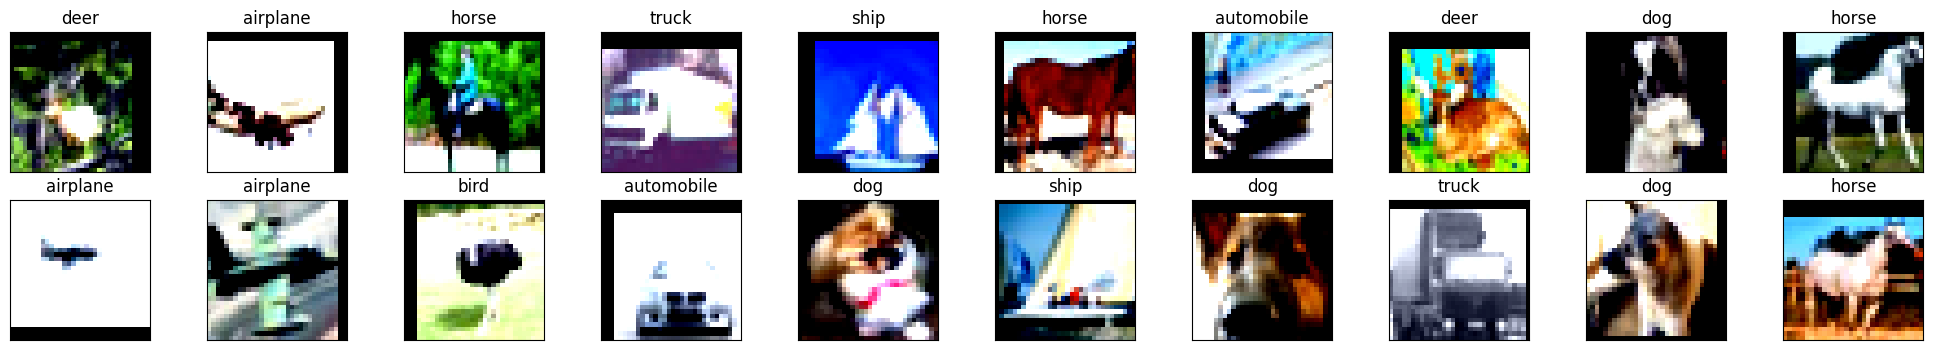

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

#**View an Image in More Detail**
Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

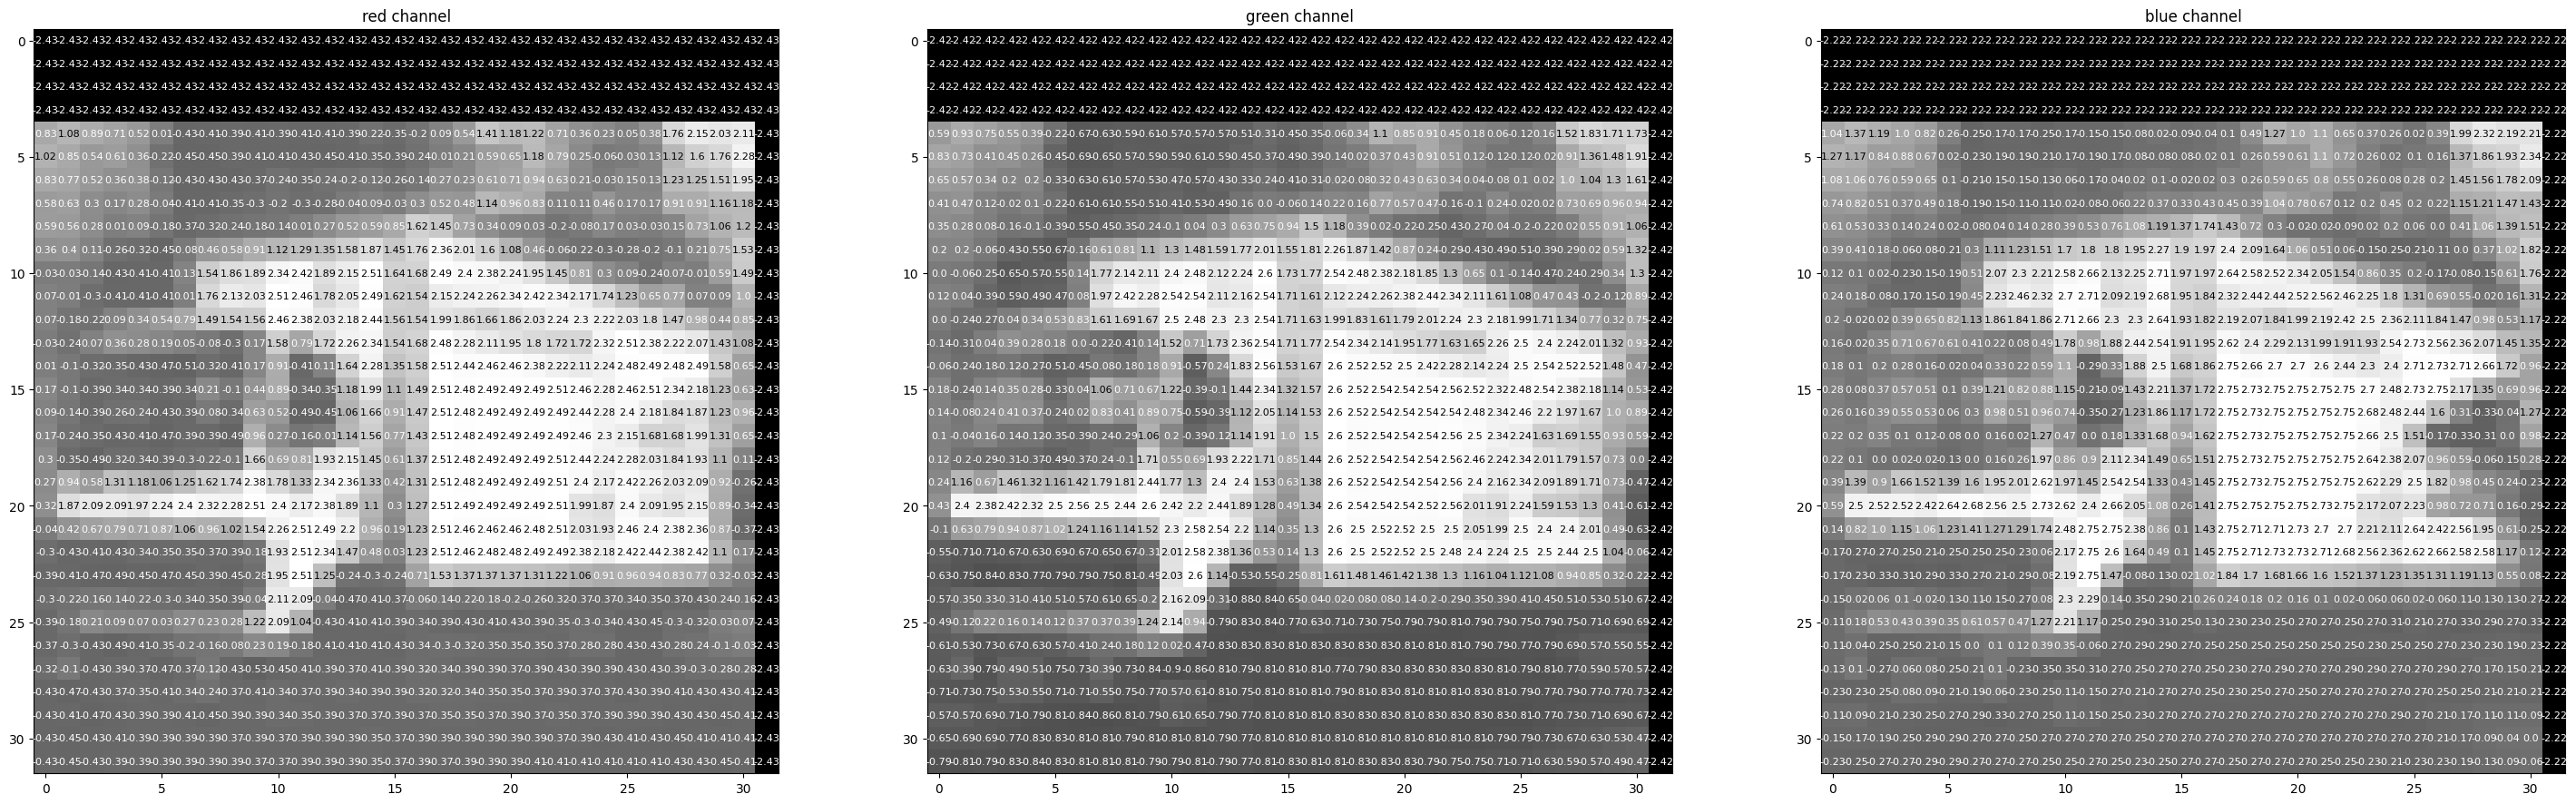

In [4]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
  ax = fig.add_subplot(1, 3, idx + 1)
  img = rgb_img[idx]
  ax.imshow(img, cmap='gray')
  ax.set_title(channels[idx])
  width, height = img.shape
  thresh = img.max()/2.5
  for x in range(width):
    for y in range(height):
      val = round(img[x][y],2) if img[x][y] !=0 else 0
      ax.annotate(str(val), xy=(y,x),
      horizontalalignment='center',
      verticalalignment='center', size=8,
      color='white' if img[x][y]<thresh else 'black')

#**Defining the Network Architecture**
ResNet9 architecture is described in https://github.com/davidcpage/cifar10-fast/tree/master



In [5]:
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F

class ConvBN(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return F.relu(self.bn(self.conv(x)))

class Residual(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.res1 = ConvBN(channels, channels)
    self.res2 = ConvBN(channels, channels)

  # downsampling not required when number of input and output channels are the same
  def forward(self, x):
    out = self.res2(self.res1(x))
    out = out + x # identity shortcut connection
    return out

class Layer(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.convbn = ConvBN(in_channels, out_channels)
    self.pool = nn.MaxPool2d(2)

  def forward(self, x):
    return self.pool(self.convbn(x))

class ResLayer(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.layer = Layer(in_channels, out_channels)
    self.residual = Residual(out_channels)

  def forward(self, x):
    return self.residual(self.layer(x))

class ResNet9(nn.Module):
  def __init__(self, input_size=32, num_classes=10):
    super().__init__()
    self.prep = ConvBN(3, 2*input_size)
    self.layer1 = ResLayer(2*input_size, 4*input_size)
    self.layer2 = Layer(4*input_size, 8*input_size)
    self.layer3 = ResLayer(8*input_size, 16*input_size)
    #self.pool = nn.MaxPool2d(4)
    #self.flatten = nn.Flatten()
    self.linear = nn.Linear(16*input_size, 10, bias=False)

  def forward(self, x):
    x = self.prep(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = F.avg_pool2d(x, 4)
    x = x.view(x.size(0), -1)
    x = self.linear(x)
    return x

In [6]:
in_size = 32
input = torch.randn(20,3,in_size,in_size)
model = ResNet9(input_size=in_size)
q_model_fp8 = ResNet9(input_size=in_size)
q_model_int12 = ResNet9(input_size=in_size)
q_model_int8 = ResNet9(input_size=in_size)
q_model_int4 = ResNet9(input_size=in_size)

## ResNet18 Module

In [ ]:
class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_planes, planes, stride=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class BottleNeck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(BottleNeck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes , planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes :
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

ResNet18 = ResNet(BasicBlock, [2,2,2,2])
#ResNet34 = ResNet(BasicBlock, [3,4,6,3])
#ResNet50 = ResNet(BottleNeck, [3,4,6,3])
#ResNet101 = ResNet(BottleNeck, [3,4,23,3])
#ResNet152 = ResNet(BottleNeck, [3,8,36,3])

import torch
in_size = 32
input = torch.randn(20,3,32,32)
model = ResNet(BasicBlock, [2,2,2,2])
print(model(input).shape)

torch.Size([20, 10])


In [ ]:
if train_on_gpu:
  ResNet18 = torch.nn.DataParallel(ResNet18)
  cudnn.benchmark = True

## Total ResNet9 model parameters

In [ ]:
model = ResNet9()
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f'total parameters: {total_params}')

if train_on_gpu:
  model = torch.nn.DataParallel(model)
  cudnn.benchmark = True

ResNet9(
  (prep): ConvBN(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer1): ResLayer(
    (layer): Layer(
      (convbn): ConvBN(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (residual): Residual(
      (res1): ConvBN(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (res2): ConvBN(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tru

#**Specifying the Loss Function and Optimizer**
We use CrossEntropyLoss as Loss function and

[Stochastic Gradient Descent](https://leon.bottou.org/publications/pdf/compstat-2010.pdf) as Optimizer with momentum and weight decay specified by the research paper of ResNet

In [7]:
import torch.optim as optim
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

# FP8 to FX Quantization Error

In [51]:
bits_to_keep = 4

def extract_components(fp8):
    """
    Given an FP8 number in SEEEMMMM format:
      - Bit 0 is the sign ('0' for positive, '1' for negative)
      - Bits 1–3 are the 3-bit exponent (E3)
      - Bits 4–7 are the 4-bit mantissa (M4)
    Returns a tuple: (sign, exponent, mantissa)
    """
    sign = fp8[0]
    exponent = int(fp8[1:4], 2)
    mantissa = fp8[4:]
    return sign, exponent, mantissa

def extend_mantissa(mantissa):
    """
    Extends the 4-bit FP8 mantissa into a 13-bit fixed-point value.
    Form the 12-bit integer portion as: "01" + mantissa (4 bits) + "000000".
    Then append a fractional bit of 0 (the binary point is implicit).
    Returns the 13-bit value as an integer.
    """
    int_str = "01" + mantissa + "000000"  # 2 + 4 + 6 = 12 bits
    int_part = int(int_str, 2)
    return int_part << 1  # Append a fractional 0 to get 13 bits

def exponent_shift(val, bits_to_shift):
    """
    Shifts the given 13-bit value right by the exponent-based shift amount.
    (No sticky bit is captured during this shift.)
    """
    return val >> bits_to_shift

def second_shift(val):
    """
    Shifts the 13-bit fixed-point value right by (12 - bits_to_keep) bits.
    While shifting, the dropped bits are OR’ed together to yield a sticky bit.
    Returns a tuple: (pre_round, sticky)
      - pre_round: the fixed-point number now has one fractional bit (rightmost)
      - sticky: 1 if any dropped bit is 1, else 0.
    """
    shift_amt = 12 - bits_to_keep
    mask = (1 << shift_amt) - 1
    sticky = 1 if (val & mask) != 0 else 0
    pre_round = val >> shift_amt
    return pre_round, sticky

def ieee_round_value(pre_round, sticky):
    """
    Rounds a fixed-point number (with one fractional bit) using IEEE 754
    round-to-nearest, ties-to-even.
    The value is assumed to have:
       integer part = pre_round >> 1 and fractional part = pre_round & 1.
    The sticky bit is used to break ties.
    Returns the rounded integer.
    """
    frac = pre_round & 1
    int_part = pre_round >> 1
    if frac == 1:
        if sticky == 1:
            return int_part + 1
        else:
            return int_part + 1 if (int_part & 1) else int_part
    else:
        return int_part

# ----------------------------
# FP_TO_FX is now the same as the original process_fp8_numbers.
def FP_TO_FX(fp8_numbers):
    """
    Processes a list of 64 FP8 numbers (one row) according to the following steps:
      1. Determine MAX_E (the highest exponent among the 64 numbers).
      2. For each FP8 number:
           - Extend the 4-bit mantissa into a 13-bit fixed-point value (format: 01MMMM000000.0).
           - Shift right by (MAX_E - exponent) for exponent-based alignment.
           - Apply a second right shift by (12 - bits_to_keep) and capture a sticky bit.
           - Save the value from immediately after the exponent-based shift (stored_before_second_shift).
           - Round using IEEE 754 round-to-nearest, ties-to-even.
           - Check the bit at index "bits_to_keep" (with index 0 being the rightmost/fractional bit):
                • If MAX_E equals 7 and that bit is 1, undo the rounding (using the stored value after exponent shift).
                • If MAX_E is less than 7 and that bit is 1, mark a flag for the post-processing step.
      3. If the flag is set, then for every FP8 number in the row:
           - Use its stored_before_second_shift value, shift it right by (13 - bits_to_keep) bits,
             compute the sticky bit of the dropped bits, and round (IEEE 754 round-to-nearest, ties-to-even).
           - Increment MAX_E by 1.
      4. Shift every final converted mantissa left by (12 - bits_to_keep) bits to align the output.
      5. Truncate the result to exactly 12 bits.
      6. If the original FP8 sign bit is '1', convert the final value to 12-bit two's complement.
    Returns a tuple: (list of 12-bit binary string results, final MAX_E)
    """
    # 1. Determine MAX_E among the 64 FP8 numbers.
    exponents = [extract_components(fp8)[1] for fp8 in fp8_numbers]
    MAX_E = max(exponents)
    shift_flag = False
    results = []

    # First loop: process each FP8 number and store the value immediately after exponent-based shift.
    for fp8 in fp8_numbers:
        sign, exponent, mantissa = extract_components(fp8)
        conv = extend_mantissa(mantissa)
        shift_amt = MAX_E - exponent
        shifted_val = exponent_shift(conv, shift_amt)
        # Save the value BEFORE the second shift.
        stored_before_second_shift = shifted_val
        # Now apply the second shift as before.
        pre_round, sticky = second_shift(shifted_val)
        rounded = ieee_round_value(pre_round, sticky)
        # Check the bit at index "bits_to_keep" (index 0 is the rightmost/fractional bit)
        bit_at_index = (rounded >> (bits_to_keep - 1)) & 1
        if MAX_E == 7:
            if bit_at_index == 1:
                # Undo rounding by using the stored value from before the second shift.
                rounded = pre_round >> 1
        elif MAX_E < 7:
            if bit_at_index == 1:
                shift_flag = True
        results.append({'sign': sign, 'value': rounded,
                        'stored_before_second_shift': stored_before_second_shift})

    # 3. Post-processing: only apply if the flag is set.
    if shift_flag:
        MAX_E += 1
        for item in results:
            sp = item['stored_before_second_shift']
            new_shift_amt = 13 - bits_to_keep
            mask = (1 << new_shift_amt) - 1
            sticky = 1 if (sp & mask) != 0 else 0
            new_pre_round = sp >> new_shift_amt
            item['value'] = ieee_round_value(new_pre_round, sticky)

    # 4 & 5. Align the final result: shift left by (12 - bits_to_keep) bits and truncate to 12 bits.
    final_results = []
    for item in results:
        final_val = item['value'] << (12 - bits_to_keep)
        final_val &= (1 << 12) - 1  # ensure exactly 12 bits
        # 6. Apply two's complement if original sign is '1'
        if item['sign'] == '1':
            final_val = ((~final_val) + 1) & ((1 << 12) - 1)
        final_results.append(format(final_val, '012b'))

    return final_results, MAX_E
# ----------------------------

def FX_TO_FP(fx_output, max_e):
    """
    Converts a list of 12-bit fixed-point (FX) numbers (given as binary strings)
    into FP8 format with an 8-bit SEEEMMMM representation:
      - S: Sign bit (1 if the FX number is negative, 0 if positive)
      - EEE: 3-bit exponent computed as (max_e + 1 - number of leading zeros)
      - MMMM: 4-bit mantissa extracted starting two bits to the right of the first '1'
    If the FX magnitude is zero then returns "00000000" for that number.
    """
    fp8_results = []
    for fx in fx_output:
        # Convert binary string to integer.
        fx_val = int(fx, 2)
        # Determine if negative by checking the 12th bit (bit index 11).
        if fx_val & (1 << 11):
            # Negative: convert to magnitude using two's complement.
            magnitude = ((~fx_val) + 1) & ((1 << 12) - 1)
            sign_bit = '1'
        else:
            magnitude = fx_val
            sign_bit = '0'

        if magnitude == 0:
            fp8_str = "00000000"
        else:
            # Convert magnitude to a 12-bit binary string.
            bin_str = f"{magnitude:012b}"
            try:
                lz = bin_str.index("1")
            except ValueError:
                lz = 12
            # Compute exponent as (max_e + 1 - number of leading zeros).
            exponent_val = max_e + 1 - lz
            exponent = f"{exponent_val:03b}"
            # Extract 4 bits of mantissa starting two bits to the right of the first '1'.
            mantissa = bin_str[lz+1: lz+5]
            mantissa = mantissa.ljust(4, "0")
            fp8_str = f"{sign_bit}{exponent}{mantissa}"
        fp8_results.append(fp8_str)
    return fp8_results

def FP_TO_FX_TO_FP(fp8_numbers):
    """
    End-to-end conversion:
      - Takes a list of 64 FP8 numbers (each in SEEEMMMM format)
      - Converts them to 12-bit FX using FP_TO_FX
      - Then converts those FX numbers back to FP8 using FX_TO_FP
    Returns a list of 8-bit FP8 outputs (SEEEMMMM) for the 64 numbers.
    """
    fx_output, max_e = FP_TO_FX(fp8_numbers)
    fp8_converted = FX_TO_FP(fx_output, max_e)
    return fp8_converted

In [52]:
from itertools import product

e_bits = 3
m_bits = 4
e_bias = 2 ** (e_bits-1) - 1

def generate_bin_e3m4():
  grid = []

  # all possible e3m4 binary values
  for S in product('01'):
    for E in product('01', repeat=e_bits):
      for M in product('01', repeat=m_bits):
        if not (E == ('1',) * e_bits and M == ('1',) * m_bits): # ignore NaN
          if E != ('0',) * e_bits or M == ('0',) * m_bits: # ignore subnormal numbers
            bin = S + E + M
            grid.append(bin)
  return grid

def bin_to_str(x: tuple[str, ...]) -> str:
  return ''.join(x)

def str_to_bin(x: str) -> tuple[str, ...]:
  return tuple(x)

def decode_bin_e3m4(x: tuple[str, ...]) -> float:
  S = x[0]
  E = x[1:e_bits+1]
  M = x[e_bits+1:]

  E_val = sum([2 ** (e_bits-i-1) * int(a) for i,a in enumerate(E)])

  M_val = sum([2 ** -(i+1) * int(a) for i,a in enumerate(M)])
  if E_val != 0:
    M_val = M_val + 1

  value = ((-1) ** int(S)) * 2 ** (E_val - e_bias) * M_val
  return value

fp8_bin = generate_bin_e3m4()
fp8_values = [decode_bin_e3m4(x) for x in fp8_bin]
print(*fp8_values)

0.0 0.25 0.265625 0.28125 0.296875 0.3125 0.328125 0.34375 0.359375 0.375 0.390625 0.40625 0.421875 0.4375 0.453125 0.46875 0.484375 0.5 0.53125 0.5625 0.59375 0.625 0.65625 0.6875 0.71875 0.75 0.78125 0.8125 0.84375 0.875 0.90625 0.9375 0.96875 1.0 1.0625 1.125 1.1875 1.25 1.3125 1.375 1.4375 1.5 1.5625 1.625 1.6875 1.75 1.8125 1.875 1.9375 2.0 2.125 2.25 2.375 2.5 2.625 2.75 2.875 3.0 3.125 3.25 3.375 3.5 3.625 3.75 3.875 4.0 4.25 4.5 4.75 5.0 5.25 5.5 5.75 6.0 6.25 6.5 6.75 7.0 7.25 7.5 7.75 8.0 8.5 9.0 9.5 10.0 10.5 11.0 11.5 12.0 12.5 13.0 13.5 14.0 14.5 15.0 15.5 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 -0.0 -0.25 -0.265625 -0.28125 -0.296875 -0.3125 -0.328125 -0.34375 -0.359375 -0.375 -0.390625 -0.40625 -0.421875 -0.4375 -0.453125 -0.46875 -0.484375 -0.5 -0.53125 -0.5625 -0.59375 -0.625 -0.65625 -0.6875 -0.71875 -0.75 -0.78125 -0.8125 -0.84375 -0.875 -0.90625 -0.9375 -0.96875 -1.0 -1.0625 -1.125 -1.1875 -1.25 -1.3125 -1.375 -1.4375 -1.5 -1.5625 

In [53]:
import numpy as np

def symm_quant_fx(x: list[float], n_bits):
  alpha = max(x)
  scale = 2 ** (n_bits - 1) / alpha
  return [round_fp8(round(scale * i) / scale) for i in x]

def round_fp8(x: float) -> float:
  fp8_bin = generate_bin_e3m4()
  fp8_values = [decode_bin_e3m4(x) for x in fp8_bin]

  i = np.argmin(np.abs(np.subtract(fp8_values, x)))
  return fp8_values[i]

def q_mse(x: list[float], q: list[float]) -> float:
  return sum([(a - b)**2 for a,b in zip(x, q)]) / len(x)

In [54]:
import random
import pandas as pd

n = 64
x_fp8_bin = random.sample(fp8_bin, n)
q_x_fp8_bin = [str_to_bin(y) for y in FP_TO_FX_TO_FP([bin_to_str(x) for x in x_fp8_bin])]

x_fp8 = [decode_bin_e3m4(a) for a in x_fp8_bin]
q_fx = [decode_bin_e3m4(a) for a in q_x_fp8_bin]
mse_fx = q_mse(x_fp8, q_fx)

q_int12 = symm_quant_fx(x_fp8, 12)
mse_int12 = q_mse(x_fp8, q_int12)

q_int8 = symm_quant_fx(x_fp8, 8)
mse_int8 = q_mse(x_fp8, q_int8)

q_int4 = symm_quant_fx(x_fp8, 4)
mse_int4 = q_mse(x_fp8, q_int4)

df_FX = pd.DataFrame({
    "FP8": x_fp8,
    "FP->FX->FP": q_fx,
    "int12": q_int12,
    "int8": q_int8,
    "int4": q_int4
})

print(df_FX)
print("quantized MSE")
print(df_FX.apply(lambda x: q_mse(x_fp8, x), axis=0))

[('0', '0', '0', '0', '0', '0', '0', '0'), ('0', '0', '0', '0', '0', '0', '0', '0'), ('1', '1', '1', '0', '1', '0', '0', '0'), ('1', '1', '0', '1', '0', '0', '0', '0'), ('1', '1', '1', '0', '1', '0', '0', '0'), ('0', '0', '0', '0', '0', '0', '0', '0'), ('0', '1', '1', '0', '0', '0', '0', '0'), ('1', '1', '1', '0', '1', '0', '0', '0'), ('0', '0', '0', '0', '0', '0', '0', '0'), ('0', '0', '0', '0', '0', '0', '0', '0'), ('1', '1', '1', '0', '0', '0', '0', '0'), ('0', '0', '0', '0', '0', '0', '0', '0'), ('1', '1', '0', '1', '0', '0', '0', '0'), ('0', '0', '0', '0', '0', '0', '0', '0'), ('0', '1', '0', '1', '0', '0', '0', '0'), ('1', '1', '0', '1', '0', '0', '0', '0'), ('0', '0', '0', '0', '0', '0', '0', '0'), ('0', '0', '0', '0', '0', '0', '0', '0'), ('1', '1', '0', '1', '0', '0', '0', '0'), ('0', '0', '0', '0', '0', '0', '0', '0'), ('0', '0', '0', '0', '0', '0', '0', '0'), ('0', '1', '1', '1', '1', '1', '0', '0'), ('1', '1', '0', '1', '0', '0', '0', '0'), ('0', '0', '0', '0', '0', '0', '0

# Quantization

In [44]:
def fx_quantization(x: torch.Tensor, fx_bits: int) -> torch.Tensor:
  alpha = torch.max(x)
  scale = 2 ** (fx_bits - 1) / alpha
  return torch.round(scale * x) / scale

def round_e3m4(x: torch.Tensor) -> torch.Tensor:
  M = 4
  elem_scale = (2 ** (torch.floor(torch.log2(x)) - M))
  quantize_x = torch.round(torch.div(x, elem_scale))
  dequantize_x = torch.mul(quantize_x, elem_scale)
  remove_sub_x = torch.where(dequantize_x < 0.25, torch.round(dequantize_x * 4)/4, dequantize_x) # any subnormal values are rounded to either 0 or 0.25
  return remove_sub_x

def e3m4_fx_quantization(x: torch.Tensor, fx_bits: int) -> torch.Tensor:
  E = 3
  M = torch.tensor(4)

  maxval = torch.max(x)
  minval = -maxval

  bias = 2**E - torch.log2(maxval) + torch.log2(2 - 2 ** (-M)) - 1
  xc = torch.min(torch.max(x, minval), maxval)

  log_scales = torch.clamp((torch.floor(torch.log2(torch.abs(xc)) + bias)).detach(), 1.0)
  scales = 2.0 ** (log_scales - M - bias)

  quantize_e3m4 = torch.round(xc / scales) # FP32 -> FP8
  quantize_fx = round_e3m4(fx_quantization(quantize_e3m4, fx_bits)) # FP8 -> FX -> FP8
  result = quantize_fx * scales # FP8 -> FP32
  return result

In [45]:
def e3m4_quantization(x_float):
  E = 3
  M = torch.tensor(4)

  maxval = torch.max(x_float)
  minval = -maxval

  bias = 2**E - torch.log2(maxval) + torch.log2(2 - 2 ** (-M)) - 1
  xc = torch.min(torch.max(x_float, minval), maxval)

  log_scales = torch.clamp((torch.floor(torch.log2(torch.abs(xc)) + bias)).detach(), 1.0)
  scales = 2.0 ** (log_scales - M - bias)

  result = torch.round(xc / scales) * scales
  return result

# **Loading Model Parameters**

In [46]:
from collections import OrderedDict
import numpy as np

state_dict = torch.load('ResNet9.pt') if train_on_gpu else torch.load('ResNet9.pt', map_location=torch.device('cpu'))

if state_dict:
  if train_on_gpu:
    new_state_dict = OrderedDict()
    for k,v in state_dict.items():
      new_state_dict[k[7:]] = v
    state_dict = new_state_dict

<ipython-input-46-10065294f631>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('ResNet9.pt') if train_on_gpu else torch.load('ResNet9.pt', map_loca

In [47]:
# extract model weight
weights = {k: state_dict[k] for k in state_dict.keys() if k[-6:] == 'weight'}

# per-tensor quantization
weights_fp8 = {k: e3m4_quantization(w) for k,w in weights.items()}
weights_int12 = {k: fx_quantization(w,12) for k,w in weights.items()}
weights_int8 = {k: fx_quantization(w,8) for k,w in weights.items()}
weights_int4 = {k: fx_quantization(w,4) for k,w in weights.items()}

state_dict_fp8 = {k: weights_fp8[k] if k in weights.keys() else state_dict[k] for k in state_dict.keys()}
state_dict_int12 = {k: weights_int12[k] if k in weights.keys() else state_dict[k] for k in state_dict.keys()}
state_dict_int8 = {k: weights_int8[k] if k in weights.keys() else state_dict[k] for k in state_dict.keys()}
state_dict_int4 = {k: weights_int4[k] if k in weights.keys() else state_dict[k] for k in state_dict.keys()}

#**Training Loop**
Here we train the architecture on training data and check its validation loss by using the validation set and saving the model only if there is an improvement ie decrease in the validation loss.

In [ ]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
  # keep track of training and validation loss
  train_loss = 0.0
  valid_loss = 0.0

  ###################
  # train the model #
  ###################
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer.step()
    # update training loss
    train_loss += loss.item()*data.size(0)

  ######################
  # validate the model #
  ######################
  model.eval()
  for batch_idx, (data, target) in enumerate(valid_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update average validation loss
    valid_loss += loss.item()*data.size(0)

  # calculate average losses
  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)

  # print training/validation statistics
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch, train_loss, valid_loss))

  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
    valid_loss_min,
    valid_loss))
    torch.save(model.state_dict(), 'ResNet9.pt')
    valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.169954 	Validation Loss: 0.362444
Validation loss decreased (inf --> 0.362444).  Saving model ...
Epoch: 2 	Training Loss: 0.161163 	Validation Loss: 0.358472
Validation loss decreased (0.362444 --> 0.358472).  Saving model ...
Epoch: 3 	Training Loss: 0.157088 	Validation Loss: 0.329444
Validation loss decreased (0.358472 --> 0.329444).  Saving model ...
Epoch: 4 	Training Loss: 0.148842 	Validation Loss: 0.332210
Epoch: 5 	Training Loss: 0.139856 	Validation Loss: 0.355565
Epoch: 6 	Training Loss: 0.135464 	Validation Loss: 0.360148
Epoch: 7 	Training Loss: 0.130675 	Validation Loss: 0.373274
Epoch: 8 	Training Loss: 0.130674 	Validation Loss: 0.361194
Epoch: 9 	Training Loss: 0.122998 	Validation Loss: 0.388195
Epoch: 10 	Training Loss: 0.116316 	Validation Loss: 0.377413
Epoch: 11 	Training Loss: 0.115497 	Validation Loss: 0.398848
Epoch: 12 	Training Loss: 0.111900 	Validation Loss: 0.359577
Epoch: 13 	Training Loss: 0.107490 	Validation Loss: 0.382095
E

#**Loading the Best Model**

In [48]:
if not state_dict:
  state_dict = torch.load('ResNet9.pt')

model.load_state_dict(state_dict)
q_model_fp8.load_state_dict(state_dict_fp8)
q_model_int12.load_state_dict(state_dict_int12)
q_model_int8.load_state_dict(state_dict_int8)
q_model_int4.load_state_dict(state_dict_int4)

<All keys matched successfully>

#**Testing Loop**
The real test of the model architecture how well does the model recognizes the image and what is the accuracy on the test data

In [49]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

m = q_model_fp8

if train_on_gpu:
  m.cuda()

m.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
  # move tensors to GPU if CUDA is available
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()
  # forward pass: compute predicted outputs by passing inputs to the model
  output = m(data)
  # calculate the batch loss
  loss = criterion(output, target)
  # update test loss
  test_loss += loss.item()*data.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  # compare predictions to true label
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  # calculate test accuracy for each object class
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %.1f%% (%3d/%2d)' % (
        classes[i], 100 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.345897

Test Accuracy of airplane: 93.0% (930/1000)
Test Accuracy of automobile: 94.4% (944/1000)
Test Accuracy of  bird: 86.5% (865/1000)
Test Accuracy of   cat: 76.7% (767/1000)
Test Accuracy of  deer: 88.2% (882/1000)
Test Accuracy of   dog: 87.2% (872/1000)
Test Accuracy of  frog: 92.4% (924/1000)
Test Accuracy of horse: 90.8% (908/1000)
Test Accuracy of  ship: 95.7% (957/1000)
Test Accuracy of truck: 93.5% (935/1000)

Test Accuracy (Overall): 89.84% (8984/10000)
